In [16]:
using DrWatson
quickactivate(@__DIR__)

using NetHeider
using LinearAlgebra
using LightGraphs
using Plots
using DataFrames
using JLD2
using Statistics

include(projectdir("scripts", "notebook_res_anal_funs.jl"))

show_res (generic function with 1 method)

In [2]:
res = jldopen(datadir("sims7", "collected_results.jld2")) do file
    file["res"]
end
first(res, 10)

,inform_every,add_edges,m_filename,pr_neg,padd,measure_balance_every_step
,Float64?,#add_sin…?,String?,Float64?,Float64?,Int64?
1,0.25,add_single_edge2!,results.csv,0.05,0.01,5
2,0.25,add_single_edge2!,results.csv,0.15,0.01,5
3,0.25,add_single_edge2!,results.csv,0.1,0.01,5
4,0.25,add_single_edge2!,results.csv,0.25,0.01,5
5,0.25,add_single_edge2!,results.csv,0.2,0.01,5
6,0.25,add_single_edge2!,results.csv,0.3,0.01,5
7,0.25,add_single_edge2!,results.csv,0.05,0.01,5
8,0.25,add_single_edge2!,results.csv,0.15,0.01,5
9,0.25,add_single_edge2!,results.csv,0.1,0.01,5


In [3]:
names(res)[1:end]

40-element Vector{String}:
 "inform_every"
 "add_edges"
 "m_filename"
 "pr_neg"
 "padd"
 "measure_balance_every_step"
 "bal2not_mean2"
 "net_str"
 "balanced_std"
 "N"
 ⋮
 "unbal2bal_mean2"
 "triads_num"
 "last_val"
 "unbal2bal_mean"
 "attr"
 "pn"
 "save_after"
 "bal2bal_mean2"
 "path"

In [4]:
size(res)

(5760, 40)

In [5]:
unique(res.pr_pos)

6-element Vector{Union{Missing, Float64}}:
 0.05
 0.15
 0.1
 0.25
 0.2
 0.3

In [6]:
# parameters
pn = 1.
pclose_triad = 0.
pr_pos = pr_neg = 0.3
padd = 0.01
threshold = [0:15...]/16

fields = Symbol.(["pn", "pclose_triad", "pr_pos", "pr_neg", "padd", "threshold"])
values = []

dict = @dict pn pclose_triad pr_pos pr_neg padd threshold

L = nrow(res)

# which_rows = zeros(Bool, L)
cropped_res = deepcopy(res)
for (field, values) in dict
    inds = findall(x->x in values, cropped_res[:, field])
    # display(length(inds))
    # display(field)
    cropped_res = cropped_res[inds,:]
end

display(nrow(cropped_res))

16

# Finding best simulation parameters

In [7]:
real_trans_df = jldopen(datadir("exp_pro", "real_randomized_triad_trans_results.jld2")) do file
    file["res"]
end
first(real_trans_df, 10)

,threshold,netsense_b2b,netsense_u2b,node_rand_b2b,node_rand_u2b,node_rand_b2b_std
,Float64,Any,Any,Any,Any,Any
1,0.0,0.4,0.0175439,0.2,0.00258333,0.18041
2,0.0625,0.2,0.0769231,0.374167,0.0163158,0.164333
3,0.125,0.631579,0.209302,0.486538,0.0582,0.11894
4,0.1875,0.612903,0.451613,0.560926,0.120694,0.0817351
5,0.25,0.794872,0.391304,0.696765,0.224655,0.0609315
6,0.3125,0.731707,0.619048,0.752222,0.332889,0.0561586
7,0.375,0.837209,0.736842,0.776813,0.406,0.0481336
8,0.4375,0.891304,0.375,0.817742,0.371515,0.0432376
9,0.5,0.869565,0.625,0.816774,0.400303,0.0430357


In [9]:

fname = datadir("exp_pro", "sim_add_each_turn_compared_to_rl_sims7_withT_allT.jld2")
if isfile(fname)
    results_df = jldopen(fname) do file
        file["res"]
    end
    display(first(results_df, 3))

    calc_errors = false
else
    calc_errors = true
end

true

In [10]:
# parameters
pn = unique(res.pn)
pclose_triad = unique(res.pclose_triad)
pr_pos = pr_neg = unique(res.pr_pos)
padd = unique(res.padd)
threshold = [0:15...]/16

# time_points = [45, 90, 135, 180, 270]
time_points = [5:5:400...]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

if calc_errors
    x = dicts[1]
    results_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
    results_df.dict_ind = [0]
    results_df.time_ind = [0.]
    results_df.mse = [0.]
    results_df.mae = [0.]
    results_df.mse_notbeg = [0.]
    results_df.mae_notbeg = [0.]
    results_df.T_mse_notbeg = [0.]
    results_df.T_mae_notbeg = [0.]
    results_df.mse_manyT = [0.]
    results_df.mae_manyT = [0.]
    delete!(results_df, 1)

    for (dict_ind, dict) in enumerate(dicts)
        if dict["pr_pos"] != dict["pr_neg"]
            continue
        end
        
        cropped_res = get_part_dataframe(res, dict; verbose =false)
        if nrow(cropped_res) == 0
            display(dict)
        end
        for (i, time_ind) in enumerate(time_inds)
            xvals = cropped_res[:, :threshold]
            b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
            u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

            #sorting, just in case
            inds = sortperm(xvals)
            xvals = xvals[inds]
            b2b_vals = b2b_vals[inds]
            u2b_vals = u2b_vals[inds]

            @assert xvals == real_trans_df.threshold

            mse = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
            mae = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
            mse_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
            mae_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")
            T_mse_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "T--_mse_notbeg")
            T_mae_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "T--_mae_notbeg")
            mse_manyT = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_manyT")
            mae_manyT = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_manyT")

            x = dict
            temp_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
            temp_df.dict_ind = [dict_ind]
            temp_df.time_ind = [time_ind]
            temp_df.mse = [mse]
            temp_df.mae = [mae]
            temp_df.mse_notbeg = [mse_notbeg]
            temp_df.mae_notbeg = [mae_notbeg]
            temp_df.T_mse_notbeg = [T_mse_notbeg]
            temp_df.T_mae_notbeg = [T_mae_notbeg]
            temp_df.mse_manyT = [mse_manyT]
            temp_df.mae_manyT = [mae_manyT]
            
            append!(results_df, temp_df)
        end
    end

    # foldername = "exp_pro"

    # fname = datadir(foldername, "sim_add_each_turn_compared_to_rl_sims7_withT.jld2")
    jldopen(fname, "w") do file
        file["res"] = results_df
    end;
end

,padd,pr_neg,pn,pclose_triad,pr_pos,dict_ind,time_ind,mse,mae
,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64
1,0.01,0.05,0.0,0.0,0.05,1,1.0,5.76323,9.71377
2,0.01,0.05,0.0,0.0,0.05,1,2.0,5.0525,8.56608
3,0.01,0.05,0.0,0.0,0.05,1,3.0,4.69017,7.92788
4,0.01,0.05,0.0,0.0,0.05,1,4.0,4.03773,7.41575
5,0.01,0.05,0.0,0.0,0.05,1,5.0,3.56448,6.88669
6,0.01,0.05,0.0,0.0,0.05,1,6.0,3.48649,6.67258
7,0.01,0.05,0.0,0.0,0.05,1,7.0,3.35533,6.4418
8,0.01,0.05,0.0,0.0,0.05,1,8.0,3.55362,6.37753
9,0.01,0.05,0.0,0.0,0.05,1,9.0,3.41053,6.14019


In [12]:
cols = [:mse, :mae, :mse_notbeg, :mae_notbeg, :mse_manyT, :mae_manyT]
inds = zeros(Int, length(cols))
for (i, col) in enumerate(cols)
    inds2 = findall(results_df[:, col] .== minimum(results_df[:, col]))
    if length(inds2) > 1
        display(inds2)
    end
    inds[i] = inds2[1]
end
inds

6-element Vector{Int64}:
 3554
  421
  422
  422
  417
  417

In [13]:
#finding 10 best param sets

cols = [:mse, :mae, :mse_notbeg, :mae_notbeg, :T_mse_notbeg, :T_mae_notbeg, :mse_manyT, :mae_manyT]
mulinds = zeros(Int, length(cols), 10)
valinds = zeros(length(cols), 10)
for (i, col) in enumerate(cols)
    inds2 = partialsortperm(results_df[:, col], 1:10)
    
    mulinds[i,:] = inds2
    valinds[i,:] = results_df[inds2, col]
end
mulinds


8×10 Matrix{Int64}:
  3554    421   3552   2825   3553   3153   3156   3169   420   3173
   421    420    419    422    498    418    497   3382   424    423
   422    421    420    426  22663    427   2825  22662   423   3152
   422    421    420   3152    419    424   3153    423   426    498
 22663  22661  22662    422    421  22664    426    420   427   4907
   421    420    422  22663   6019  22662  22660  22659  4907  22661
   417    418    416    419   3773    422    415    421  1214   3534
   417    418    419   7459   7460    416    422    658   421   3773

In [14]:
valinds

8×10 Matrix{Float64}:
 1.30649   1.32057   1.32146   1.32204   …  1.33287   1.33473   1.33489
 3.71699   3.75684   3.77765   3.82746      3.90663   3.91159   3.92049
 0.429501  0.440589  0.453088  0.454293     0.48032   0.484355  0.489705
 2.09181   2.13535   2.15385   2.23368      2.26445   2.27565   2.29583
 0.379047  0.391481  0.392115  0.395069     0.407748  0.419441  0.422235
 1.58962   1.60936   1.61057   1.62326   …  1.7083    1.72153   1.72329
 0.149589  0.165196  0.175085  0.177616     0.197678  0.200037  0.200213
 1.34079   1.39035   1.45772   1.46443      1.57742   1.57762   1.59779

In [17]:
show_res(results_df, dicts, 417)

show_res(results_df, dicts, 421)

show_res(results_df, dicts, 422)

show_res(results_df, dicts, 418)

show_res(results_df, dicts, 419)

"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"85.0"

"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"105.0"

"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"110.0"

"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"90.0"

"Dict(\"padd\" => 0.01, \"pr_neg\" => 0.05, \"pn\" => 0.2, \"pclose_triad\" => 0.0, \"pr_pos\" => 0.05)"

"95.0"

## Assuming pn=0.4

In [18]:
# fname = datadir("exp_pro", "sim_add_each_turn_compared_to_rl_sims7_withT_allT.jld2")
fname = datadir("exp_pro", "sim_add_each_turn_compared_to_rl_sims7_pn0_4_withT_allT.jld2")
if isfile(fname)
    results_df = jldopen(fname) do file
        file["res"]
    end
    display(first(results_df, 3))

    calc_errors = false
else
    calc_errors = true
end

true

In [19]:
# parameters
pn = [0.4]
pclose_triad = unique(res.pclose_triad)
pr_pos = pr_neg = unique(res.pr_pos)
padd = unique(res.padd)
threshold = [0:15...]/16

# time_points = [45, 90, 135, 180, 270]
time_points = [5:5:400...]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict pn padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

if calc_errors
    x = dicts[1]
    results_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
    results_df.dict_ind = [0]
    results_df.time_ind = [0.]
    results_df.mse = [0.]
    results_df.mae = [0.]
    results_df.mse_notbeg = [0.]
    results_df.mae_notbeg = [0.]
    results_df.mse_manyT = [0.]
    results_df.mae_manyT = [0.]
    delete!(results_df, 1)

    for (dict_ind, dict) in enumerate(dicts)   
        if dict["pr_pos"] != dict["pr_neg"]
            continue
        end
        
        cropped_res = get_part_dataframe(res, dict; verbose =false)
        if nrow(cropped_res) == 0
            display(dict)
        end
        for (i, time_ind) in enumerate(time_inds)
            xvals = cropped_res[:, :threshold]
            b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
            u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

            #sorting, just in case
            inds = sortperm(xvals)
            xvals = xvals[inds]
            b2b_vals = b2b_vals[inds]
            u2b_vals = u2b_vals[inds]

            @assert xvals == real_trans_df.threshold

            mse = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
            mae = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
            mse_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
            mae_notbeg = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")
            mse_manyT = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_manyT")
            mae_manyT = calc_error(b2b_vals, u2b_vals, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_manyT")
            

            x = dict
            temp_df = DataFrame(;[Symbol(k)=>v for (k,v) in x]...)
            temp_df.dict_ind = [dict_ind]
            temp_df.time_ind = [time_ind]
            temp_df.mse = [mse]
            temp_df.mae = [mae]
            temp_df.mse_notbeg = [mse_notbeg]
            temp_df.mae_notbeg = [mae_notbeg]
            temp_df.mse_manyT = [mse_manyT]
            temp_df.mae_manyT = [mae_manyT]
            
            append!(results_df, temp_df)
        end
    end


    jldopen(fname, "w") do file
        file["res"] = results_df
    end;
end

,padd,pr_neg,pn,pclose_triad,pr_pos,dict_ind,time_ind,mse,mae
,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64
1,0.01,0.05,0.4,0.0,0.05,1,1.0,5.58322,9.68092
2,0.01,0.05,0.4,0.0,0.05,1,2.0,4.95021,8.78854
3,0.01,0.05,0.4,0.0,0.05,1,3.0,4.36265,7.93178
4,0.01,0.05,0.4,0.0,0.05,1,4.0,4.09639,7.43707
5,0.01,0.05,0.4,0.0,0.05,1,5.0,3.8662,6.97813
6,0.01,0.05,0.4,0.0,0.05,1,6.0,3.21946,6.12075
7,0.01,0.05,0.4,0.0,0.05,1,7.0,3.13994,5.89442
8,0.01,0.05,0.4,0.0,0.05,1,8.0,2.91811,5.5387
9,0.01,0.05,0.4,0.0,0.05,1,9.0,2.71306,5.39133


In [20]:
cols = [:mse, :mae, :mse_notbeg, :mae_notbeg]
inds = zeros(Int, length(cols))
for (i, col) in enumerate(cols)
    inds2 = findall(results_df[:, col] .== minimum(results_df[:, col]))
    if length(inds2) > 1
        display(inds2)
    end
    inds[i] = inds2[1]
end
inds

4-element Vector{Int64}:
  754
  582
 3863
  583

In [21]:
#finding 10 best param sets

cols = [:mse, :mae, :mse_notbeg, :mae_notbeg, :mse_manyT, :mae_manyT]
mulinds = zeros(Int, length(cols), 10)
valinds = zeros(length(cols), 10)
for (i, col) in enumerate(cols)
    inds2 = partialsortperm(results_df[:, col], 1:10)
    
    mulinds[i,:] = inds2
    valinds[i,:] = results_df[inds2, col]
end
mulinds


6×10 Matrix{Int64}:
  754   752   753   755   756   757   750   751   582   758
  582   583   581    22   752   753   585   755    21    20
 3863  3862  3864  3861  3865  3860  3859   752  3866   754
  583   581   582   752    22  3863   757   753    27  3862
  734   972   973   733  1136   656  1134  2893   177  1137
  583   734   582   579   177    22   656   972   733   173

In [22]:
valinds

6×10 Matrix{Float64}:
 1.30649   1.32146   1.32475   1.34119   …  1.41895   1.47346   1.49274
 3.90663   3.93994   4.02517   4.0469       4.10402   4.11795   4.11838
 0.468643  0.48032   0.492558  0.498875     0.6029    0.608662  0.608867
 2.35976   2.40894   2.42705   2.46279      2.54463   2.55115   2.5529
 0.200213  0.201174  0.21725   0.218395     0.223947  0.227466  0.228812
 1.68538   1.69995   1.70207   1.71872   …  1.74294   1.76331   1.7642

In [23]:

show_res(results_df, dicts, 583)
show_res(results_df, dicts, 734)
show_res(results_df, dicts, 582)
show_res(results_df, dicts, 3863)
# show_res(results_df, dicts, 72)
# show_res(results_df, dicts, 62)


"Dict(\"padd\" => 0.05, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"115.0"

"Dict(\"padd\" => 0.09, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"70.0"

"Dict(\"padd\" => 0.05, \"pr_neg\" => 0.05, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.05)"

"110.0"

"Dict(\"padd\" => 0.07, \"pr_neg\" => 0.2, \"pn\" => 0.4, \"pclose_triad\" => 0.35, \"pr_pos\" => 0.2)"

"115.0"

In [58]:
real_trans_df = jldopen(datadir("exp_pro", "real_randomized_triad_trans_results.jld2")) do file
    file["res"]
end
1+1;

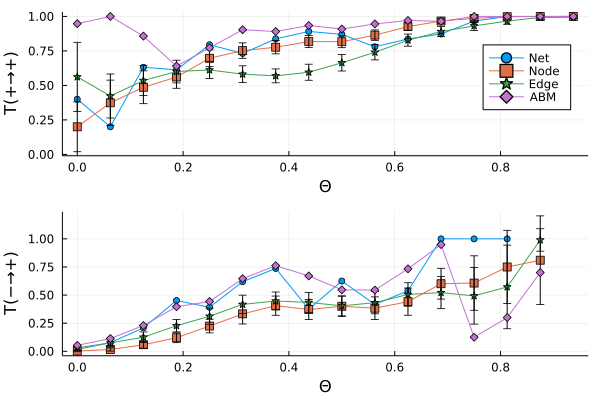

In [68]:
# parameters
pn = 0.4
pclose_triad = 0.
pr_pos = pr_neg = 0.15
padd = 0.05
threshold = [0:15...]/16

time_step = 90
time_ind = Int(time_step / 5)

fields = Symbol.(["pn", "pclose_triad", "pr_pos", "pr_neg", "padd", "threshold"])
values = []

dict = @dict pn pclose_triad pr_pos pr_neg padd threshold

L = nrow(res)

# which_rows = zeros(Bool, L)
cropped_res = deepcopy(res)
for (field, values) in dict
    inds = findall(x->x in values, cropped_res[:, field])
    # display(length(inds))
    # display(field)
    cropped_res = cropped_res[inds,:]
end

b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

xvals = real_trans_df.threshold
p1 = plot(xvals, real_trans_df.netsense_b2b, 
    markershape = :circle, label = "Net", legend = :right)#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_b2b, yerror = real_trans_df.node_rand_b2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_b2b, yerror = real_trans_df.edge_rand_b2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)
plot!(xvals, b2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)

markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

# p1 = plot(legend = :outertopright)
ylabel!("T(+→+)")
p2 = plot(legend = false)

plot!(xvals, real_trans_df.netsense_u2b, 
    markershape = :circle, label = "Net")#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_u2b, yerror = real_trans_df.node_rand_u2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_u2b, yerror = real_trans_df.edge_rand_u2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)
plot!(xvals, u2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)


ylabel!("T(−→+)")

plot(p1, p2, layout = (2,1))
xlabel!("Θ")

# title!("pn = 0.2, pclose_triad = 0, pr = 0.05, padd = 0.01")

In [1]:
# parameters
pn = 0.4
pclose_triad = 0.
pr_pos = pr_neg = 0.05
padd = 0.01
threshold = [0:15...]/16

time_step = 135
time_ind = Int(time_step / 5)

fields = Symbol.(["pn", "pclose_triad", "pr_pos", "pr_neg", "padd", "threshold"])
values = []

dict = @dict pn pclose_triad pr_pos pr_neg padd threshold

L = nrow(res)

# which_rows = zeros(Bool, L)
cropped_res = deepcopy(res)
for (field, values) in dict
    inds = findall(x->x in values, cropped_res[:, field])
    # display(length(inds))
    # display(field)
    cropped_res = cropped_res[inds,:]
end

b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

xvals = real_trans_df.threshold
p1 = plot(xvals, real_trans_df.netsense_b2b, 
    markershape = :circle, label = "Net", legend = :right)#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_b2b, yerror = real_trans_df.node_rand_b2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_b2b, yerror = real_trans_df.edge_rand_b2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)
plot!(xvals, b2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)

markers = [:circle, :rect, :star5, :diamond, :hexagon, :xcross, :utriangle, :dtriangle, :rtriangle, :ltriangle, :pentagon, :heptagon, :octagon, :star4, :star6, :star7, :star8, :vline, :hline, :+, :x, :cross]

# p1 = plot(legend = :outertopright)
ylabel!("T(+→+)")
p2 = plot(legend = false)

plot!(xvals, real_trans_df.netsense_u2b, 
    markershape = :circle, label = "Net")#, linestyle = :none)

plot!(xvals, real_trans_df.node_rand_u2b, yerror = real_trans_df.node_rand_u2b_std, markershape = :rect, label = "Node")#, linestyle = :none)
plot!(xvals, real_trans_df.edge_rand_u2b, yerror = real_trans_df.edge_rand_u2b_std, markershape = :star5, label = "Edge")#, linestyle = :none)
plot!(xvals, u2b_vals, markershape = :diamond, label = "ABM")#, linestyle = :none)


ylabel!("T(−→+)")

plot(p1, p2, layout = (2,1))
xlabel!("Θ")

# title!("pn = 0.2, pclose_triad = 0, pr = 0.05, padd = 0.01")

LoadError: LoadError: UndefVarError: @dict not defined
in expression starting at /home/pgorski/Desktop/programming/NetHeider/notebooks/result-analysis2_sims7_more_timestamps.ipynb:14

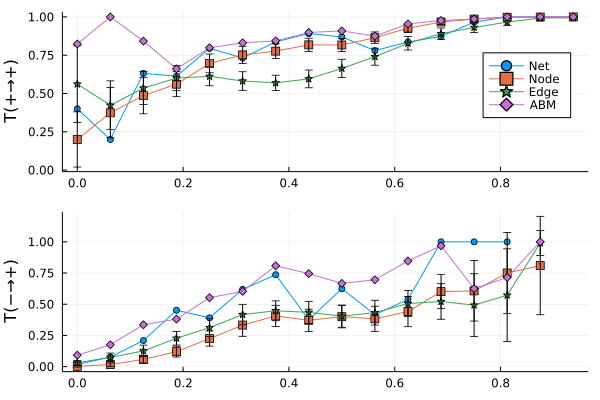

In [58]:
plot(p1, p2, layout = (2,1))

# Calculating error for edge and node randomization

In [30]:
real_trans_df

mse = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
mae = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
mse_notbeg = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
mae_notbeg = calc_error(real_trans_df.node_rand_b2b, real_trans_df.node_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

mse, mae, mse_notbeg, mae_notbeg

(0.9327230755126914, 3.908759190827624, 0.8146233317693982, 3.1628818989844203)

In [31]:

mse = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse")
mae = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae")
mse_notbeg = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mse_notbeg")
mae_notbeg = calc_error(real_trans_df.edge_rand_b2b, real_trans_df.edge_rand_u2b, real_trans_df.netsense_b2b, real_trans_df.netsense_u2b; method = "mae_notbeg")

mse, mae, mse_notbeg, mae_notbeg

(1.257523772472556, 4.379225839404921, 1.1650954074853879, 3.798715754039451)

Apart from the error for MSE the results for ABM give better approximation of the transition probabilities. 

## Triad balanced triads density

In [38]:
dicts

2940-element Vector{Dict{String, Float64}}:
 Dict("padd" => 0.01, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.03, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.05, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.07, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.09, "pr_neg" => 0.05, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.01, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.03, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.05, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.07, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 Dict("padd" => 0.09, "pr_neg" => 0.0, "pn" => 0.0, "pclose_triad" => 0.0, "pr_pos" => 0.05)
 ⋮
 Dict("padd" => 0.

In [ ]:
function plot_dict(dicts, df, param_ind)

    dict = dicts[results_df[param_ind, :dict_ind]]
    cropped_res = get_part_dataframe(res, dict)

    time_ind = Int(results_df[param_ind, :time_ind])
    xvals = cropped_res[:, :threshold]
    b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
    u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]]

    p1 = plot(xvals, b2b_vals, markershape = markers[1], label = "ABM T(+->+)")#, linestyle = :none)
    plot!(p1, xvals, u2b_vals, markershape = markers[2], label = "ABM T(-->+)")#, linestyle = :none)
    plot!(p1, real_trans_df.threshold, real_trans_df.netsense_b2b, markershape = markers[3], label = "Net T(+->+)")#, linestyle = :none)
    plot!(p1, real_trans_df.threshold, real_trans_df.netsense_u2b, markershape = markers[4], label = "Net T(-->+)")#, linestyle = :none)
    title!(p1, "steps="*string(10*time_ind))
    
    return p1
end

p1 = plot_dict(dicts, results_df, 665)
# title!(p1, string(dicts[results_df[665, :dict_ind]]))
display(string(dicts[results_df[665, :dict_ind]]))
p2 = plot_dict(dicts, results_df, 60)
display(string(dicts[results_df[60, :dict_ind]]))
# title!(p1, dicts[results_df[665, :dict_ind]])
p3 = plot_dict(dicts, results_df, 1481)
display(string(dicts[results_df[1481, :dict_ind]]))
# title!(p1, dicts[results_df[665, :dict_ind]])

plot!(p1, legend = :outertopright)
plot!(p1, legend = :outerbottom)
plot!(p2, legend = false)
plot!(p3, legend = false)

plot(p1, p2, p3, layout = (1,3))

## Influence of different pn values for specific theta

In [17]:
threshold = [14] / 16
# pn = [0.]

# parameters
# pn = [0.8]
# pclose_triad = unique(res.pclose_triad)
# pr_pos = pr_neg = unique(res.pr_pos)
# padd = unique(res.padd)
# threshold = [0:15...]/16

time_points = [45, 90, 135, 180, 270]
time_inds = Int.(time_points ./ 5)

strdicts = @strdict  threshold#padd pclose_triad pr_pos pr_neg
dicts = dict_list(strdicts)

dict = dicts[1]

cropped_res = get_part_dataframe(res, dict; verbose =false)

nrow(cropped_res)

360

In [18]:
dict

Dict{String, Float64} with 1 entry:
  "threshold" => 0.875

In [19]:
time_ind = time_inds[3]

27

In [20]:
cropped_res.b2b_vals = [val[time_ind] for val in cropped_res[:, :bal2bal_mean]]
cropped_res.u2b_vals = [val[time_ind] for val in cropped_res[:, :unbal2bal_mean]];


In [21]:
using DataFrames, GLM

lm1 = fit(LinearModel, @formula(pn ~ b2b_vals), cropped_res)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

pn ~ 1 + b2b_vals

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  -35.536      26.9772  -1.32    0.1886   -88.5897    17.5176
b2b_vals      36.0386     26.9791   1.34    0.1825   -17.0188    89.0959
────────────────────────────────────────────────────────────────────────

As expected, with small threshold pn is not important. With $\Theta=0.5$, it is very important. 

In [44]:
unique(res.pn)

6-element Vector{Union{Missing, Float64}}:
 0.0
 0.2
 0.4
 0.6
 0.8
 1.0